# UTKFace Age Regression: оценка возраста по фотографии

Проект по оценке возраста человека по фотографии его лица с помощью простой сверточной нейросети (LeNet-подобная архитектура) на датасете UTKFace.

## Цель

Предсказать числовой возраст по изображению лица (задача регрессии) и получить честный baseline по MAE на тестовой выборке.

## Датасет

- **UTKFace** — более 20k изображений лиц с разметкой возраста, пола и расы.
- Формат файлов: `[age]_[gender]_[race]_[date&time].jpg`, в этом baseline используется только метка возраста.

## Модель и технологии

- LeNet-подобная сверточная нейросеть для регрессии возраста.
- PyTorch, стандартные трансформации и DataLoader-ы.

## Итоговая метрика

- Средняя абсолютная ошибка (MAE) на тестовой выборке: **X.XX лет**.

---

В этом ноутбуке показаны:
1. Подготовка данных UTKFace и минимальный EDA.
2. Обучение LeNet-подобной модели регрессии возраста.
3. Оценка качества и примеры предсказаний на изображениях лиц.


## Импорты ⏬

In [3]:
import os
import random
import math
import json

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Настройки отображения и воспроизводимости
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


## Загрузка датасета UTKFace с Kaggle

Ниже используется Kaggle API для скачивания архива с изображениями UTKFace.
Убедитесь, что у вас настроен токен Kaggle или скачайте датасет вручную с Kaggle и поместите в папку `data/`.


In [4]:
os.makedirs("/root/.kaggle", exist_ok=True)

kaggle_config = {
    "username": "PlatinumKub",
    "key": "KGAT_04c2bc777f20afa27a8294502d460a3a"
}

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_config, f)

!chmod 600 /root/.kaggle/kaggle.json

In [5]:
# Скачивание датасета UTKFace через Kaggle API
# Требуется предварительная настройка kaggle.json

!kaggle datasets download -d jangedoo/utkface-new -p data

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 94% 311M/331M [00:06<00:00, 34.7MB/s]
100% 331M/331M [00:06<00:00, 51.6MB/s]


In [6]:
# Распаковка архива UTKFace в папку data/utkface_aligned_cropped
!unzip -q data/utkface-new.zip -d data/

In [13]:
data_dir = "data/UTKFace"  # <--- если нужно, поменяй на UTKFace или utface_aligned_cropped/crop_part1

image_paths = []
age_labels = []

for root, dirs, files in os.walk(data_dir):
    for image_name in files:
        # Нормальные имена: 41_1_3_20170104214413309.jpg.chip.jpg [web:2][web:11]
        if not image_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        components = image_name.split("_")
        try:
            age = int(components[0])
        except (ValueError, IndexError):
            continue

        age_labels.append(age)
        image_paths.append(os.path.join(root, image_name))

df = pd.DataFrame({
    "image_path": image_paths,
    "age": age_labels,
})

print("Всего строк в датафрейме:", len(df))
print("min age:", df["age"].min(), "max age:", df["age"].max())
df.head()


Всего строк в датафрейме: 23708
min age: 1 max age: 116


,image_path,age
0,data/UTKFace/28_1_2_20170116171528109.jpg.chip...,28
1,data/UTKFace/41_1_3_20170104214413309.jpg.chip...,41
2,data/UTKFace/36_0_0_20170117135436708.jpg.chip...,36
3,data/UTKFace/5_1_0_20170109191949189.jpg.chip.jpg,5
4,data/UTKFace/49_1_3_20170109141810902.jpg.chip...,49


### Пример изображения из датасета

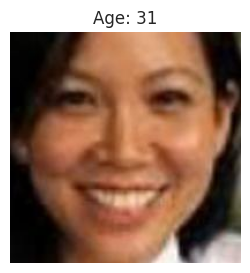

In [14]:
idx = 1000  # любой допустимый индекс
row = df.iloc[idx]

age = row["age"]
img_path = row["image_path"]

img = Image.open(img_path)

plt.figure(figsize=(3, 3))
plt.title(f"Age: {age}")
plt.axis("off")
plt.imshow(img)

### Распределение возрастов в датасете

Ниже показано распределение возрастов в UTKFace. Видно, какие возрастные группы представлены сильнее/слабее.

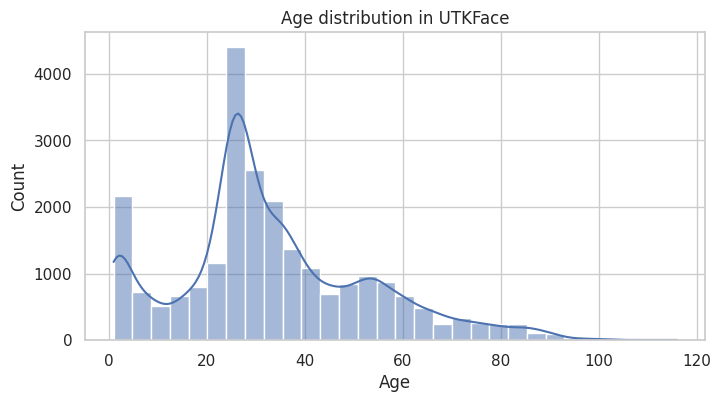

In [15]:
plt.figure(figsize=(8, 4))
sns.histplot(df["age"], bins=30, kde=True)
plt.title("Age distribution in UTKFace")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

## Подготовка данных к обучению

### Split: train/val/test

In [16]:
# Бины для стратификации (10 групп)
df['age_bin'] = pd.cut(df['age'], bins=10, labels=False)

train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['age_bin'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df['age_bin'])

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print("MAE baseline (median pred):", abs(test_df['age'] - test_df['age'].median()).mean())  # ~15 лет naive

Train: 18966, Val: 2371, Test: 2371
MAE baseline (median pred): 14.908477435681148


### Аугментации

In [17]:
IMG_SIZE = 64

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

### Кастомный Dataset

In [18]:
class UTKFaceAgeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        age = float(row["age"])

        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        age_tensor = torch.tensor(age, dtype=torch.float32)

        return img, age_tensor

### DataLoaders

In [19]:
BATCH_SIZE = 64

train_dataset = UTKFaceAgeDataset(train_df, transform=train_transform)
val_dataset   = UTKFaceAgeDataset(val_df,   transform=val_test_transform)
test_dataset  = UTKFaceAgeDataset(test_df,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

len(train_dataset), len(val_dataset), len(test_dataset)

(18966, 2371, 2371)

### Проверка

In [20]:
batch_imgs, batch_ages = next(iter(train_loader))
print("Batch images shape:", batch_imgs.shape)  # ожидаем [64, 3, 64, 64]
print("Batch ages shape:", batch_ages.shape)    # [64]
print("Примеры возрастов:", batch_ages[:10])

Batch images shape: torch.Size([64, 3, 64, 64])
Batch ages shape: torch.Size([64])
Примеры возрастов: tensor([16., 26., 12., 24.,  8., 43., 62., 49., 38., 60.])


## LeNet-подобная модель для регрессии возраста

In [21]:
class LeNetAgeRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        # Вход: [B, 3, 64, 64]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)   # -> [B, 6, 60, 60]
        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)                     # -> [B, 6, 30, 30]
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)                           # -> [B, 16, 26, 26]
        # pool -> [B, 16, 13, 13]

        # считаем размер фич после conv2+pool: 16 * 13 * 13
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)  # один выход — возраст

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # conv1 + relu + pool
        x = self.pool(F.relu(self.conv2(x)))   # conv2 + relu + pool
        x = x.view(x.size(0), -1)              # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)                        # без активации — регрессия
        return x.squeeze(1)                    # [B]

### Используем MSE как оптимизируемый лосс и MAE как читаемую метрику (в годах).

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNetAgeRegressor().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def mae_metric(preds, targets):
    # preds, targets: тензоры на CPU или GPU
    return torch.mean(torch.abs(preds - targets)).item()

### Тренировочная и валидационная функции

In [23]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    n_samples = 0

    for images, ages in tqdm(dataloader, desc="Train", leave=False):
        images = images.to(device)
        ages = ages.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, ages)
        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        running_mae += mae_metric(outputs.detach(), ages.detach()) * batch_size
        n_samples += batch_size

    epoch_loss = running_loss / n_samples
    epoch_mae = running_mae / n_samples
    return epoch_loss, epoch_mae


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_mae = 0.0
    n_samples = 0

    with torch.no_grad():
        for images, ages in tqdm(dataloader, desc="Eval", leave=False):
            images = images.to(device)
            ages = ages.to(device)

            outputs = model(images)
            loss = criterion(outputs, ages)

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size
            running_mae += mae_metric(outputs, ages) * batch_size
            n_samples += batch_size

    epoch_loss = running_loss / n_samples
    epoch_mae = running_mae / n_samples
    return epoch_loss, epoch_mae

### Цикл обучения с логированием и сохранением лучшей модели

In [24]:
EPOCHS = 30

train_losses, val_losses = [], []
train_maes, val_maes = [], []

best_val_mae = float("inf")
best_model_path = "models/lenet_age_baseline.pth"
os.makedirs("models", exist_ok=True)

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    train_loss, train_mae = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_mae = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_maes.append(train_mae)
    val_maes.append(val_mae)

    print(f"Train loss: {train_loss:.4f} | Train MAE: {train_mae:.2f}")
    print(f"Val   loss: {val_loss:.4f} | Val   MAE: {val_mae:.2f}")

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), best_model_path)
        print(f"✔ New best model saved with val MAE = {best_val_mae:.2f}")


Epoch 1/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 355.9152 | Train MAE: 14.34
Val   loss: 229.9675 | Val   MAE: 11.32
✔ New best model saved with val MAE = 11.32

Epoch 2/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 215.4617 | Train MAE: 11.09
Val   loss: 215.6003 | Val   MAE: 10.78
✔ New best model saved with val MAE = 10.78

Epoch 3/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 179.3155 | Train MAE: 10.01
Val   loss: 167.0303 | Val   MAE: 9.40
✔ New best model saved with val MAE = 9.40

Epoch 4/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 159.8246 | Train MAE: 9.39
Val   loss: 150.6101 | Val   MAE: 8.79
✔ New best model saved with val MAE = 8.79

Epoch 5/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 138.6344 | Train MAE: 8.60
Val   loss: 132.9806 | Val   MAE: 8.28
✔ New best model saved with val MAE = 8.28

Epoch 6/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 122.6508 | Train MAE: 8.00
Val   loss: 120.3997 | Val   MAE: 7.97
✔ New best model saved with val MAE = 7.97

Epoch 7/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 115.5574 | Train MAE: 7.79
Val   loss: 120.3122 | Val   MAE: 7.61
✔ New best model saved with val MAE = 7.61

Epoch 8/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 113.4054 | Train MAE: 7.68
Val   loss: 122.5501 | Val   MAE: 8.21

Epoch 9/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 104.6145 | Train MAE: 7.37
Val   loss: 112.2502 | Val   MAE: 7.34
✔ New best model saved with val MAE = 7.34

Epoch 10/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 99.4487 | Train MAE: 7.15
Val   loss: 101.6352 | Val   MAE: 7.13
✔ New best model saved with val MAE = 7.13

Epoch 11/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 94.9646 | Train MAE: 7.02
Val   loss: 100.7693 | Val   MAE: 7.10
✔ New best model saved with val MAE = 7.10

Epoch 12/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 91.5505 | Train MAE: 6.91
Val   loss: 98.4478 | Val   MAE: 7.00
✔ New best model saved with val MAE = 7.00

Epoch 13/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 89.9943 | Train MAE: 6.82
Val   loss: 128.6990 | Val   MAE: 8.61

Epoch 14/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 85.6354 | Train MAE: 6.65
Val   loss: 96.7576 | Val   MAE: 6.78
✔ New best model saved with val MAE = 6.78

Epoch 15/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 84.6719 | Train MAE: 6.63
Val   loss: 97.6442 | Val   MAE: 6.94

Epoch 16/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 80.5243 | Train MAE: 6.47
Val   loss: 109.1379 | Val   MAE: 7.38

Epoch 17/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 80.3383 | Train MAE: 6.47
Val   loss: 92.9331 | Val   MAE: 6.81

Epoch 18/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 76.2947 | Train MAE: 6.30
Val   loss: 94.0803 | Val   MAE: 6.70
✔ New best model saved with val MAE = 6.70

Epoch 19/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 73.3076 | Train MAE: 6.18
Val   loss: 86.9123 | Val   MAE: 6.49
✔ New best model saved with val MAE = 6.49

Epoch 20/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 72.9391 | Train MAE: 6.16
Val   loss: 91.4988 | Val   MAE: 6.84

Epoch 21/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 68.2070 | Train MAE: 5.98
Val   loss: 87.0237 | Val   MAE: 6.67

Epoch 22/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 66.0115 | Train MAE: 5.85
Val   loss: 86.4516 | Val   MAE: 6.64

Epoch 23/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 65.2002 | Train MAE: 5.86
Val   loss: 94.4631 | Val   MAE: 7.14

Epoch 24/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 64.0093 | Train MAE: 5.79
Val   loss: 88.6988 | Val   MAE: 6.55

Epoch 25/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 63.3981 | Train MAE: 5.78
Val   loss: 87.3995 | Val   MAE: 6.55

Epoch 26/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 60.2553 | Train MAE: 5.64
Val   loss: 90.5759 | Val   MAE: 6.59

Epoch 27/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 57.1258 | Train MAE: 5.49
Val   loss: 84.5863 | Val   MAE: 6.42
✔ New best model saved with val MAE = 6.42

Epoch 28/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 56.9002 | Train MAE: 5.48
Val   loss: 85.9745 | Val   MAE: 6.55

Epoch 29/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 55.3778 | Train MAE: 5.41
Val   loss: 82.8259 | Val   MAE: 6.40
✔ New best model saved with val MAE = 6.40

Epoch 30/30


Train:   0%|          | 0/297 [00:00<?, ?it/s]

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Train loss: 53.2744 | Train MAE: 5.31
Val   loss: 97.8968 | Val   MAE: 7.12


### Графики loss и MAE по эпохам

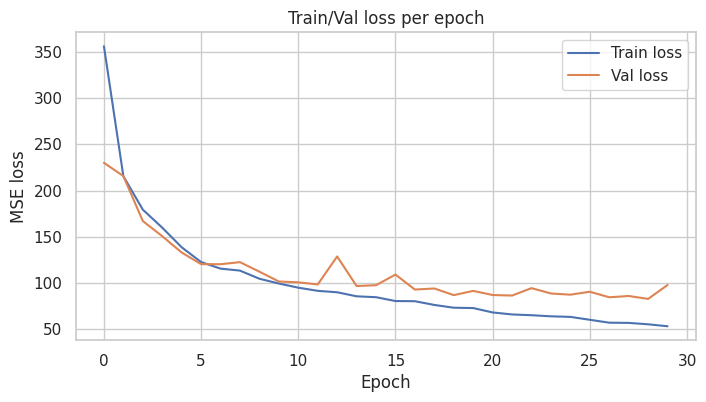

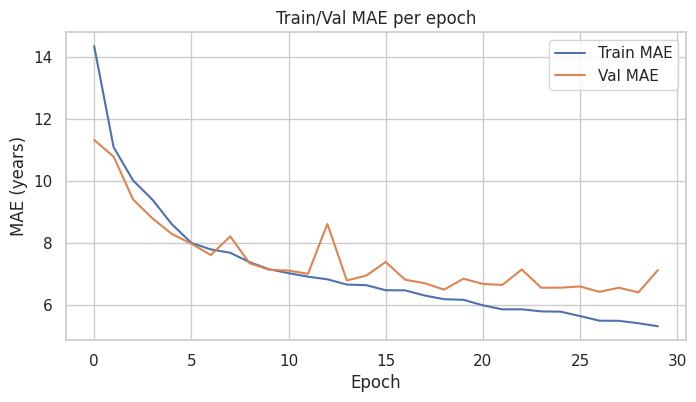

In [25]:
# График Loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Train/Val loss per epoch")
plt.legend()
plt.show()

# График MAE
plt.figure(figsize=(8, 4))
plt.plot(train_maes, label="Train MAE")
plt.plot(val_maes, label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE (years)")
plt.title("Train/Val MAE per epoch")
plt.legend()
plt.show()

## Оценка результатов

In [26]:
# Загружаем лучшую модель (по val MAE)
best_model_path = "models/lenet_age_baseline.pth"
model = LeNetAgeRegressor().to(device)
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

test_loss, test_mae = evaluate(model, test_loader, criterion, device)
print(f"Test loss (MSE): {test_loss:.4f}")
print(f"Test MAE (years): {test_mae:.2f}")

Eval:   0%|          | 0/38 [00:00<?, ?it/s]

Test loss (MSE): 77.9394
Test MAE (years): 6.12


In [27]:
# Сбор предсказаний для анализа
all_preds = []
all_targets = []

with torch.no_grad():
    for images, ages in test_loader:
        images = images.to(device)
        ages = ages.to(device)

        outputs = model(images)
        all_preds.append(outputs.cpu())
        all_targets.append(ages.cpu())

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

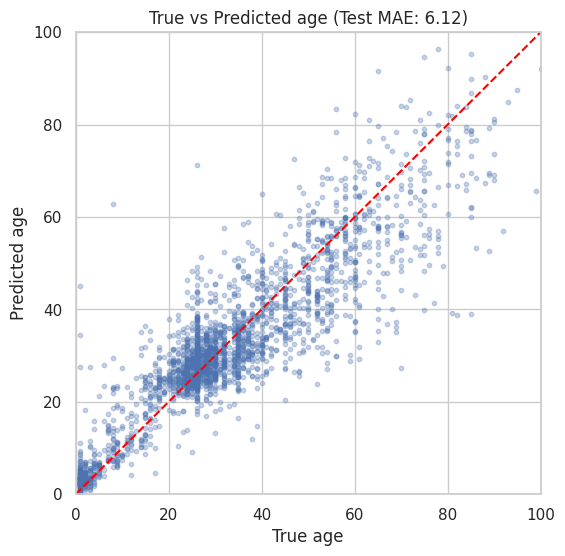

In [28]:
# Строим график разброса
plt.figure(figsize=(6, 6))
plt.scatter(all_targets, all_preds, alpha=0.3, s=10)
plt.plot([0, 100], [0, 100], color="red", linestyle="--")
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel("True age")
plt.ylabel("Predicted age")
plt.title(f"True vs Predicted age (Test MAE: {test_mae:.2f})")
plt.show()

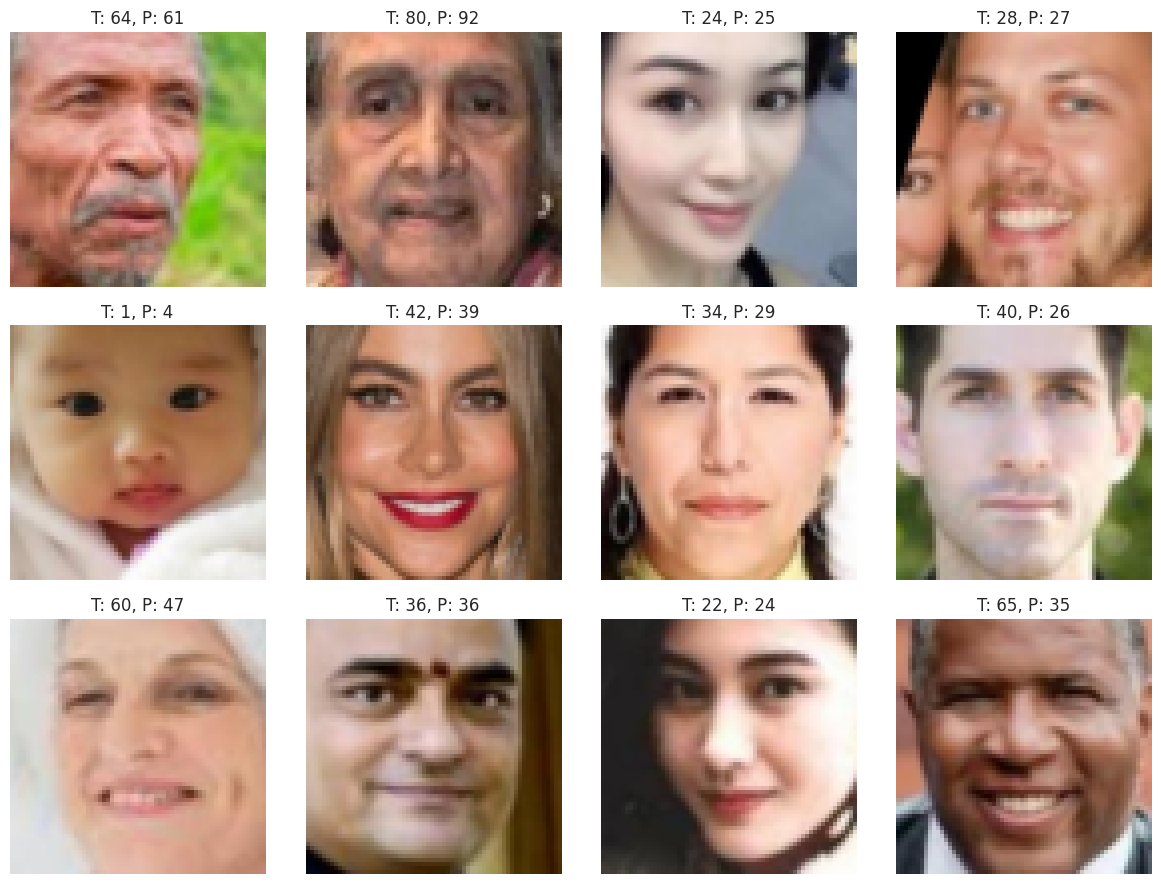

In [29]:
# @title
def denormalize(img_tensor):
    # Обратная операция к Normalize(mean=[0.5]*3, std=[0.5]*3)
    img = img_tensor.clone()
    img = img * 0.5 + 0.5  # std, mean
    img = img.clamp(0, 1)
    return img

# Берём один батч из test_loader
images, ages = next(iter(test_loader))
images = images.to(device)
ages = ages.to(device)

with torch.no_grad():
    preds = model(images)

images = images.cpu()
ages = ages.cpu().numpy()
preds = preds.cpu().numpy()

n_show = 12
rows, cols = 3, 4

plt.figure(figsize=(cols * 3, rows * 3))

for i in range(n_show):
    plt.subplot(rows, cols, i + 1)
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    true_age = int(ages[i])
    pred_age = int(round(preds[i]))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"T: {true_age}, P: {pred_age}")

plt.tight_layout()
plt.show()

## Итоговая оценка baseline-модели

- Модель: LeNet-подобная CNN, обученная с нуля на UTKFace (64x64 RGB, MSELoss, Adam).
- Датасет: UTKFace, train/val/test = 80/10/10, стратификация по возрастным бинам.
- Метрика: MAE (в годах) на тесте.

**Результат:**
- Test MAE: `6,12` лет.

Графики:
- Диаграмма `True vs Predicted age` показывает, что модель в среднем разумно оценивает возраст, но ошибается сильнее на крайних возрастах (дети и пожилые).
- Примеры изображений с подписями `T: true, P: pred` позволяют визуально оценить качество предсказаний.

 Дальнейшие улучшения могут включать более глубокие архитектуры, продвинутые аугментации и мультитаск-обучение.